## Load Data and Initial Grid Search

In [1]:
import os
BRANDON = '/Users/brandonmarks/Desktop/Research Materials/hierarchical-bayesian-model-validation/'
YASH = '/Users/yashd/Desktop/hierarchical-bayesian-model-validation/'
HANNAH = ''
ZIXUN = ''

ROOT_DIR = YASH
os.chdir(ROOT_DIR + 'testing-framework/')

SKIP_OPTIMIZE_STEP = True
CONSTANT_SAMPLE_SIZE = 100000
GROUP = 'layer'
MIN_GROUP, MAX_GROUP = 2, 8 # Should be 2, 8/9 if wavelet; 2, 14 if fourier. Inspect data_df and decide based on minimum and maximum values
DATA_NAME = 'approx1e5-full-pastis-gray-wavelet'
ORIGINAL_NAME = DATA_NAME[10:]


''' Only need to run commented code (3 lines) once'''
# os.mkdir(DATA_NAME)
# os.mkdir(os.path.join(DATA_NAME, "CSVs"))
# os.mkdir(os.path.join(DATA_NAME, "plots"))

print("Make sure this corresponds with the full name of dataset:", ORIGINAL_NAME)

Make sure this corresponds with the full name of dataset: full-pastis-gray-wavelet


In [2]:
from utilities import *
from plot_utilities import *
data_df = pd.read_pickle(f'../transformed-data/{ORIGINAL_NAME}.pickle')
data_df[GROUP].apply([min, max])

min    2
max    8
Name: layer, dtype: int64

In [3]:
''' Only need to run commented code (10 lines) once'''

min_group, max_group = MIN_GROUP, MAX_GROUP
total_samples = []
group_data_map = dict()
for group in np.arange(min_group, max_group + 1):
    if GROUP == 'layer':
        data = np.append(data_df[(data_df['orientation'] == 'H') & (data_df[GROUP] == group)]['data'].iloc[0],
                     data_df[(data_df['orientation'] == 'V') & (data_df[GROUP] == group)]['data'].iloc[0])
    elif GROUP == 'band':
        data = data_df[(data_df[GROUP] == group)]['data'].iloc[0]
    total_samples.append(data.size)
    group_data_map[group] = np.sort(data)[np.round(np.linspace(0, data.size - 1, min(data.size, CONSTANT_SAMPLE_SIZE))).astype(int)] 
pd.to_pickle(group_data_map, f'{DATA_NAME}/group_data_map.pickle')

min_group, max_group = MIN_GROUP, MAX_GROUP
group_data_map = pd.read_pickle(f'{DATA_NAME}/group_data_map.pickle')
group_data_map

{2: array([-99.93568594, -91.00645124, -88.54430615, ...,  88.80035968,
         91.52850405,  94.44944672]),
 3: array([-76.13432886, -63.02074639, -60.52416619, ...,  65.19608846,
         65.26965934,  69.44498554]),
 4: array([-51.73647153, -48.46756551, -45.83266202, ...,  48.25087164,
         50.33643736,  64.88734264]),
 5: array([-47.95678457, -36.2290875 , -34.21402956, ...,  32.91894773,
         36.11999915,  42.17747737]),
 6: array([-23.87540781, -21.69502371, -19.77842932, ...,  18.532206  ,
         21.00124659,  44.79754701]),
 7: array([-19.12997336, -11.63154378, -10.24156022, ...,  10.34018388,
         11.58181396,  20.30569957]),
 8: array([-18.71256003,  -5.38310051,  -4.75432793, ...,   4.71546986,
          5.46900035,  20.5891778 ])}

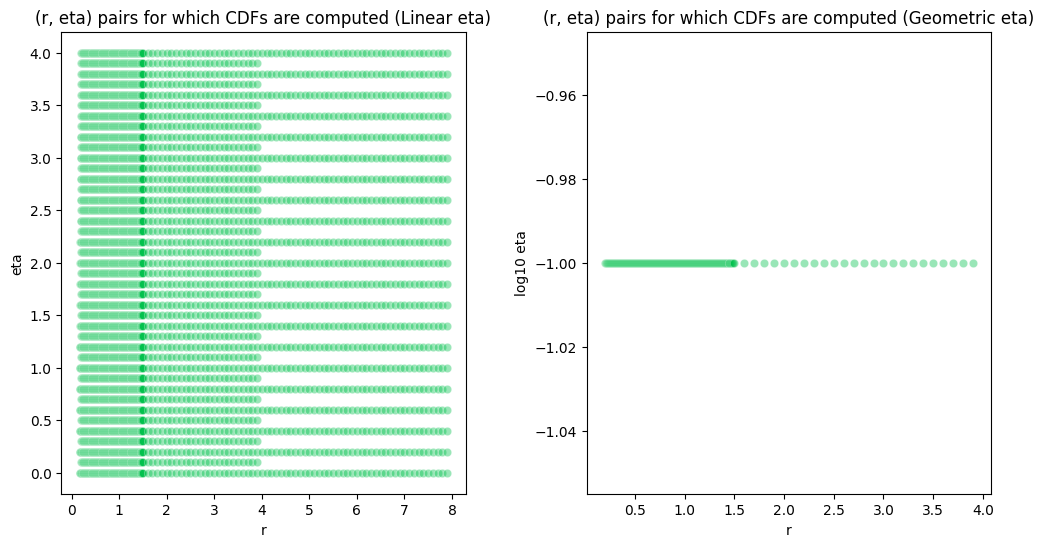

,"(r,eta),cdf",r,eta,cdf
0,"((0.17, 0), <scipy.interpolate._cubic.CubicSpl...",0.17,0.0,<scipy.interpolate._cubic.CubicSpline object a...
1,"((0.17, 0.2), <scipy.interpolate._cubic.CubicS...",0.17,0.2,<scipy.interpolate._cubic.CubicSpline object a...
2,"((0.17, 0.4), <scipy.interpolate._cubic.CubicS...",0.17,0.4,<scipy.interpolate._cubic.CubicSpline object a...
3,"((0.17, 0.6), <scipy.interpolate._cubic.CubicS...",0.17,0.6,<scipy.interpolate._cubic.CubicSpline object a...
4,"((0.17, 0.8), <scipy.interpolate._cubic.CubicS...",0.17,0.8,<scipy.interpolate._cubic.CubicSpline object a...
...,...,...,...,...
7226,"((7.9, 3.2), <scipy.interpolate._cubic.CubicSp...",7.90,3.2,<scipy.interpolate._cubic.CubicSpline object a...
7227,"((7.9, 3.4), <scipy.interpolate._cubic.CubicSp...",7.90,3.4,<scipy.interpolate._cubic.CubicSpline object a...
7228,"((7.9, 3.6), <scipy.interpolate._cubic.CubicSp...",7.90,3.6,<scipy.interpolate._cubic.CubicSpline object a...
7229,"((7.9, 3.8), <scipy.interpolate._cubic.CubicSp...",7.90,3.8,<scipy.interpolate._cubic.CubicSpline object a...


In [4]:
# Large grid search CDFs already computed (r = 0 to 8, eta = 0 to 3.9)

all_cdfs = combine_pickles('scipy_10000') | combine_pickles('mtlb_10000') | combine_pickles('mtlb_100000')
all_cdfs_df = pd.DataFrame({'(r,eta),cdf' : sorted(all_cdfs.items())})
all_cdfs_df['r'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[0])
all_cdfs_df['eta'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[0].str[1])
all_cdfs_df['cdf'] = pd.Series(all_cdfs_df["(r,eta),cdf"].str[1])

create_scatter_plots_log_eta(all_cdfs_df)

all_cdfs_df.sort_values(['r', 'eta'])

In [5]:
''' Only need to run commented code (13 lines) once'''
master_df = pd.DataFrame(columns = [GROUP, 'num_samples', 'initial_param', 'kstest_stat_initial', 'best_param_eta_0', 'kstest_stat_eta0'])
idx_eta0 = [i for i, param in enumerate(sorted(all_cdfs)) if np.isclose(param[1], 0, atol = 1e-40)]
sorted_params = sorted(all_cdfs)
for i, group in enumerate(np.arange(min_group, max_group+1)):
    print("Processing group (layer/band) ", group)
    sample = group_data_map[group]
    ksstats, initial_param, min_stat = gridsearch(sample, all_cdfs)
    ksstats_eta0 = [ksstats[i] for i in idx_eta0]
    idx_min_ksstats_eta0 = idx_eta0[np.argmin(ksstats_eta0)]
    master_df.loc[i, :] = [group, sample.size, initial_param, min_stat, sorted_params[idx_min_ksstats_eta0], ksstats[idx_min_ksstats_eta0]]
master_df = master_df.set_index(GROUP)
master_df['total_samples'] = total_samples
master_df.to_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/initial_eta0_grid.csv', index_col=GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

Processing group (layer/band)  2
Processing group (layer/band)  3
Processing group (layer/band)  4
Processing group (layer/band)  5
Processing group (layer/band)  6
Processing group (layer/band)  7
Processing group (layer/band)  8


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples
layer,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280


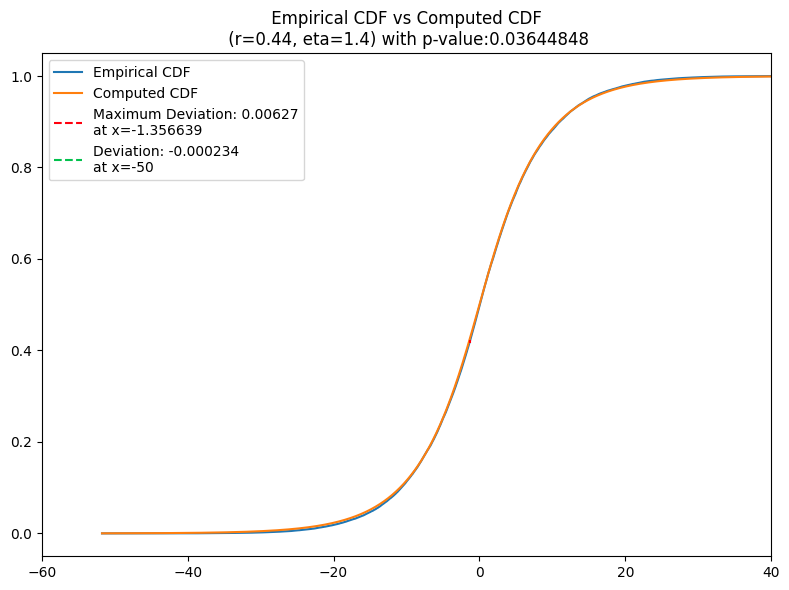

In [6]:
# To visualize a specific input
group = 4
visualize_cdf(group_data_map[group], 
              all_cdfs = all_cdfs, 
              params= master_df.loc[group, 'initial_param'], 
              n_samples=10000, interval = (-60, 40), 
              provided_loc = -50);

In [7]:
# Given that pvalue = 0.05 and I have n samples, what should the kstest statistic be?
# Note how as num_samples increases by a factor of 4, the cutoff decreases by a factor of 2
# Could potentially include the plot in `images/loglog_pvalue_numsamples.png` 

for group in np.arange(min_group, max_group+1):
    num_points = master_df.loc[group, 'total_samples'] # Note that we use total samples, not num_samples
    master_df.loc[group, 'kstest_stat_cutoff_0.05'] = stats.kstwo(n=num_points).isf(0.05)    
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples,kstest_stat_cutoff_0.05
layer,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180,0.024030
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720,0.012029
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880,0.006018
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520,0.003010
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080,0.001505
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320,0.000753
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280,0.000376


In [8]:
r_d, eta_d = 3, 2 # Controls precision to which parameters are optimized
SKIP_OPTIMIZE_STEP = True

if SKIP_OPTIMIZE_STEP:
    r_d, eta_d = 2, 1
    master_df['kstest_stat_cd'] = master_df['kstest_stat_initial']
    master_df[f'best_r_d{r_d}'] = master_df['initial_param'].apply(lambda x : x[0])
    master_df[f'best_eta_d{eta_d}'] = master_df['initial_param'].apply(lambda x : x[1])

else:
    for group in np.arange(min_group, max_group+1): 
        sample = group_data_map[group]
        initial_param = master_df.loc[group, 'initial_param']
        master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'] = coord_descent_gengamma(sample, initial_param, 
                                                                                                                    r_depth = r_d, eta_depth=eta_d, 
                                                                                                                    scipy_int=False, group=group, 
                                                                                                                    eng=eng, DATA_NAME=DATA_NAME)
        master_df.loc[group, 'kstest_stat_cd'] = compute_ksstat(sample, combine_pickles(f'{DATA_NAME}_group{group}_10000')[(master_df.loc[group, f'best_r_d{r_d}'], master_df.loc[group, f'best_eta_d{eta_d}'])])
        print(f"{GROUP} {group} best parameters: {master_df.loc[group, 'kstest_stat_cd']}")


master_df['n_pval_0.05'] = master_df.apply(lambda row : find_n_fixed_pval_stat(row.loc['kstest_stat_cd'], row.loc['total_samples']), axis = 1)    
master_df[['num_samples', 'total_samples', 'initial_param', 'kstest_stat_initial', f'best_r_d{r_d}', f'best_eta_d{eta_d}', 'kstest_stat_cd', 'n_pval_0.05']].to_csv(f'{DATA_NAME}/CSVs/optimized_params.csv')
master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_optimize.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[group]['initial_param'][1:-1].split(',')) for group in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05
layer,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180,0.024030,0.021670,0.39,4.0,4023
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720,0.012029,0.008143,0.44,3.7,28620
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880,0.006018,0.006270,0.44,1.4,48295
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520,0.003010,0.005235,0.47,0.2,64395
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080,0.001505,0.020507,0.74,0.0,4525
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320,0.000753,0.082280,6.10,0.0,279
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280,0.000376,0.227355,6.00,0.0,36


## Comparing Empirical and Computed CDF/PDF

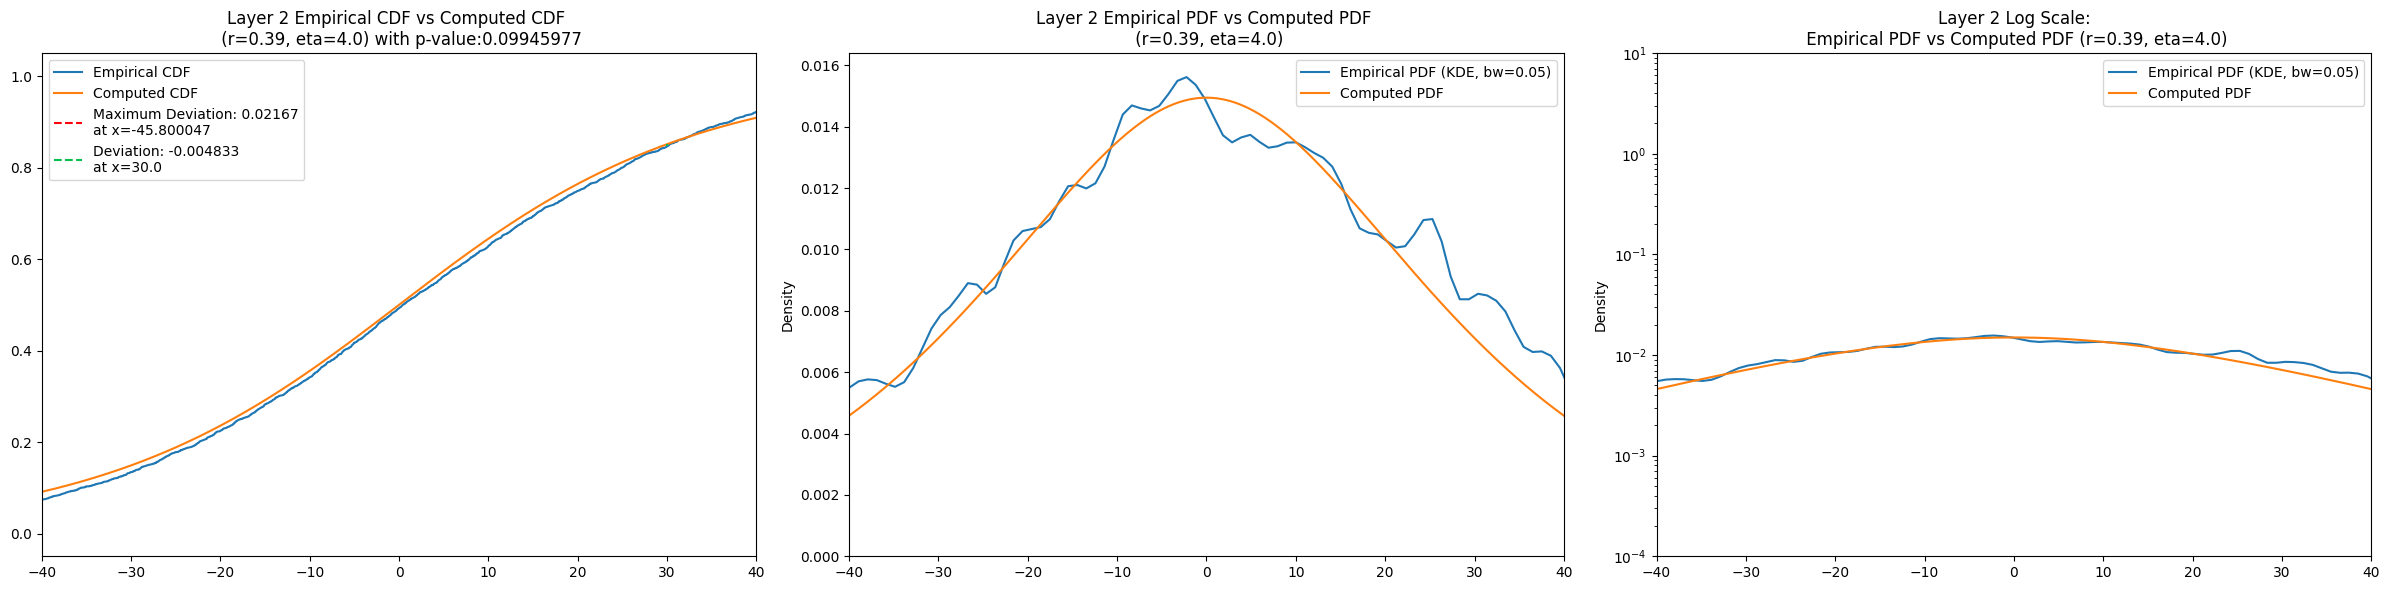

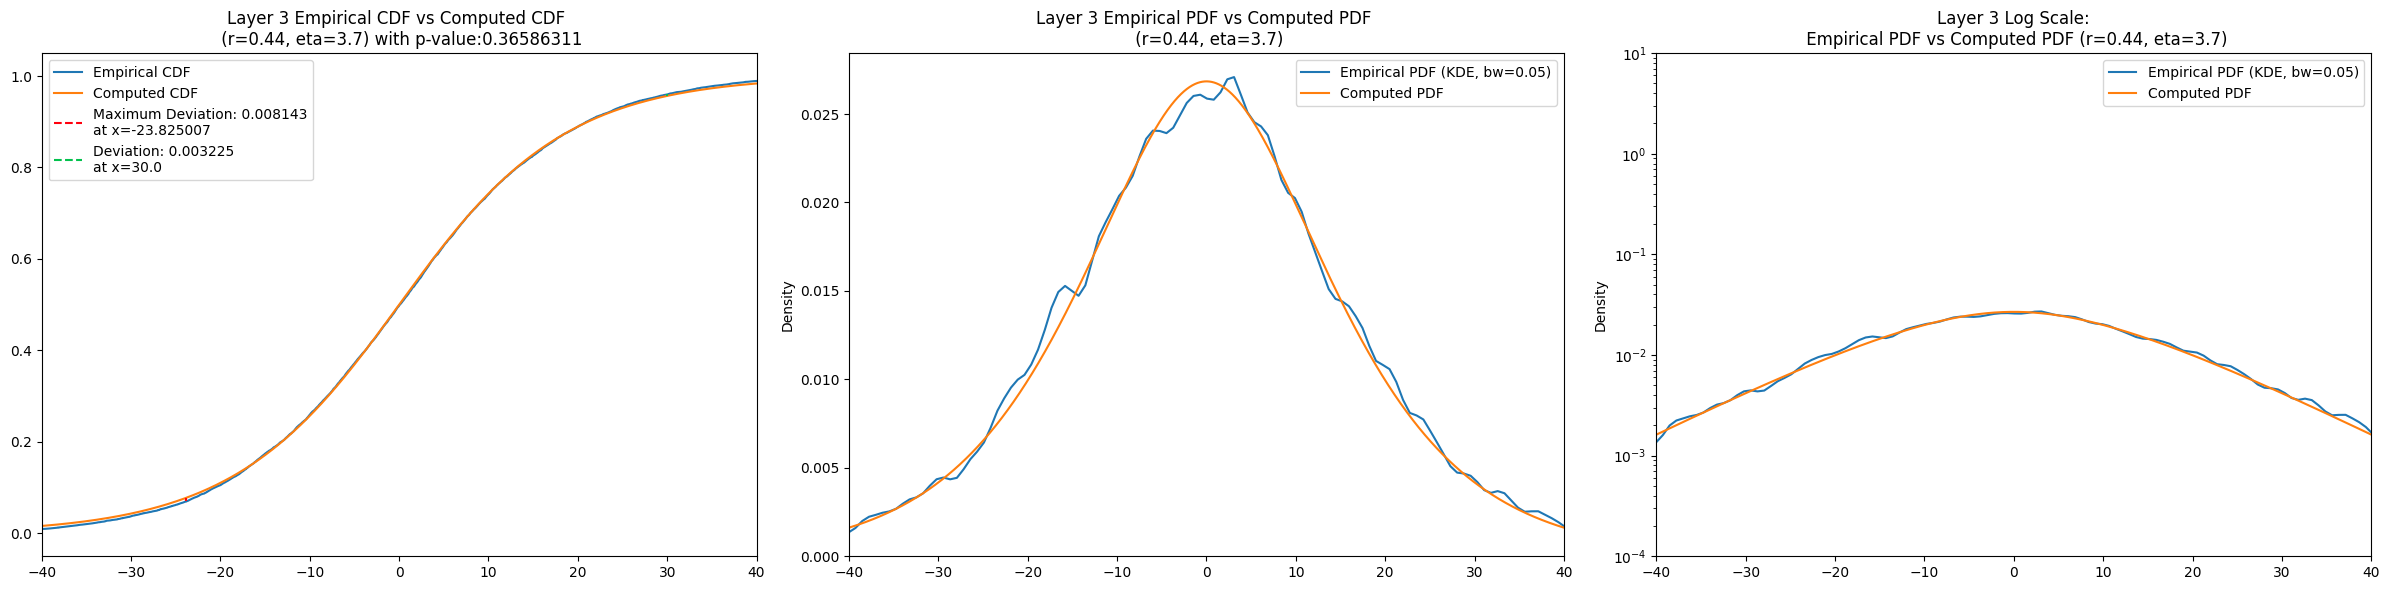

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:87: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  prior_pdf[j] = integrate.quad(integrand, 0, np.inf)[0]


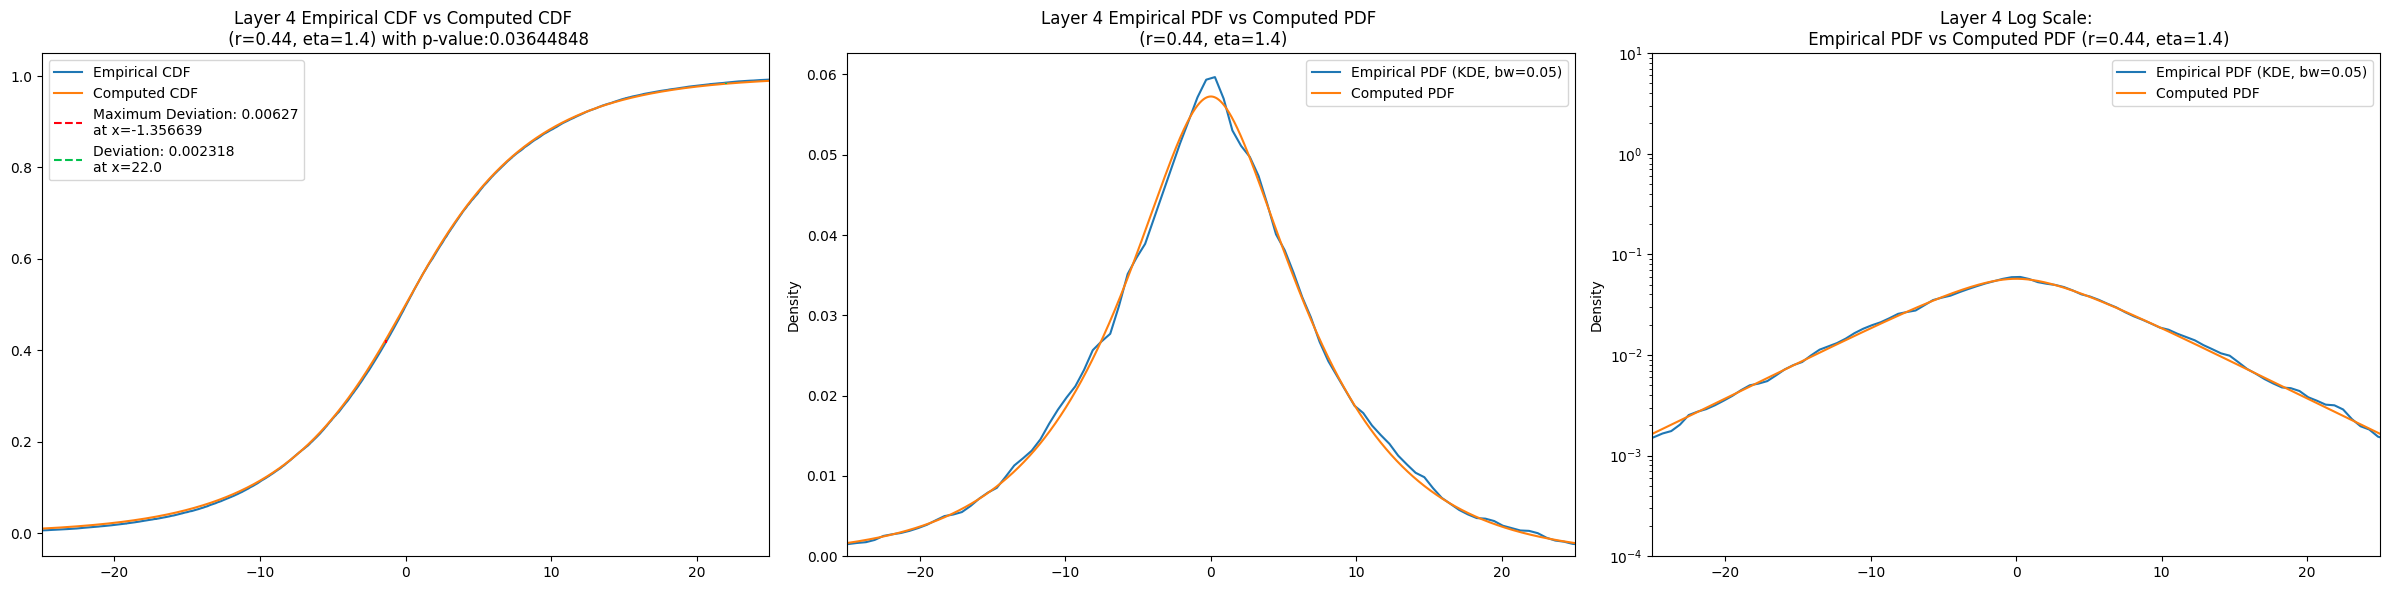

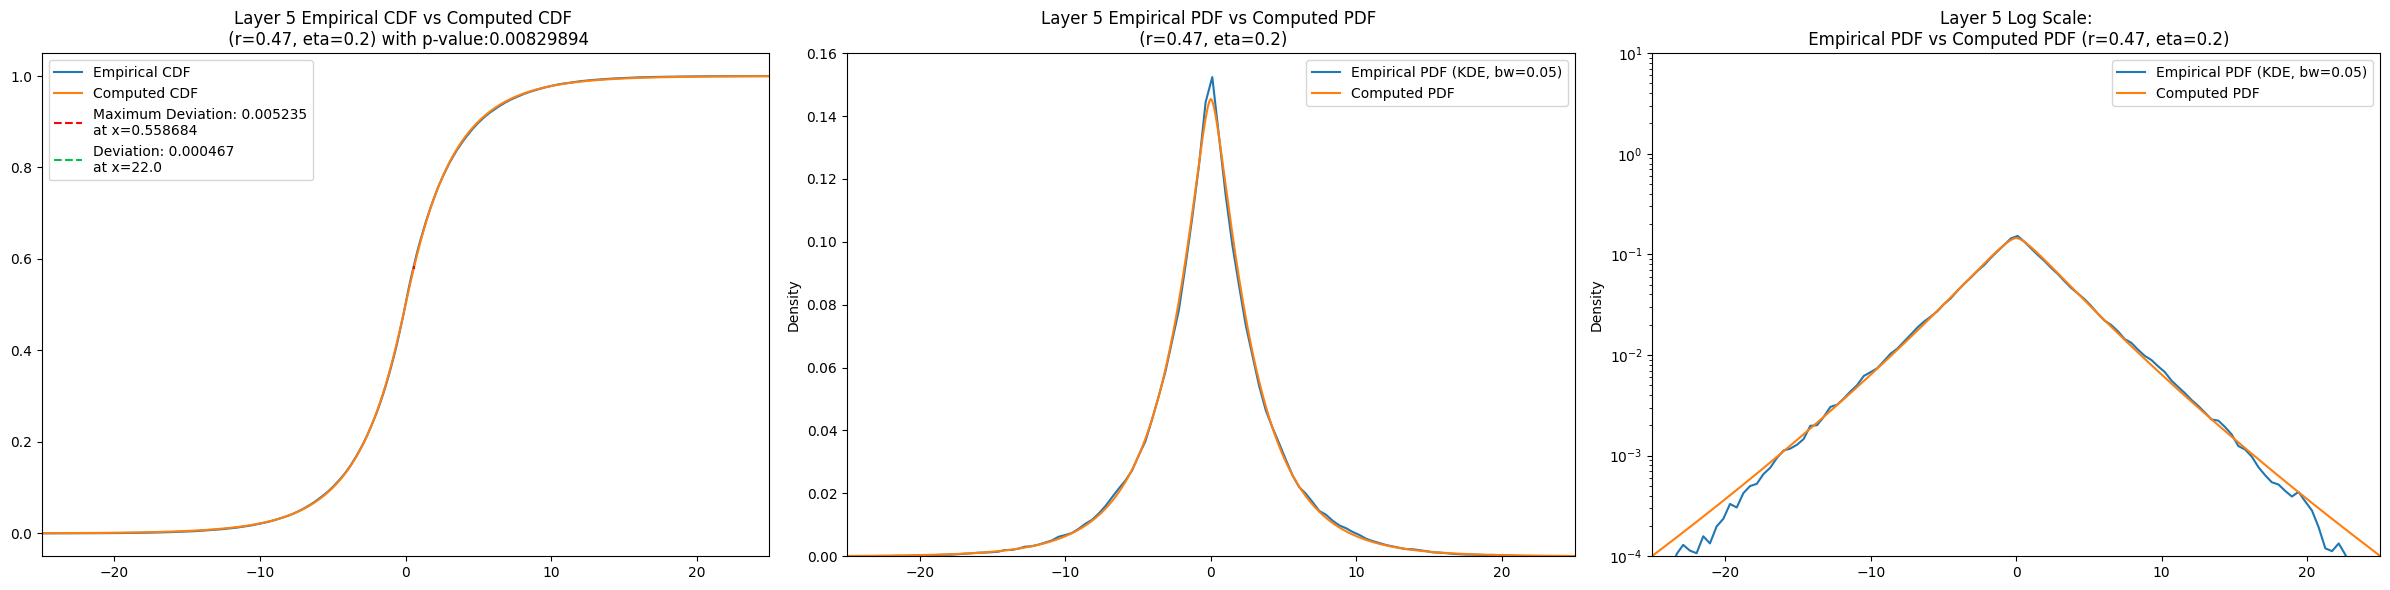

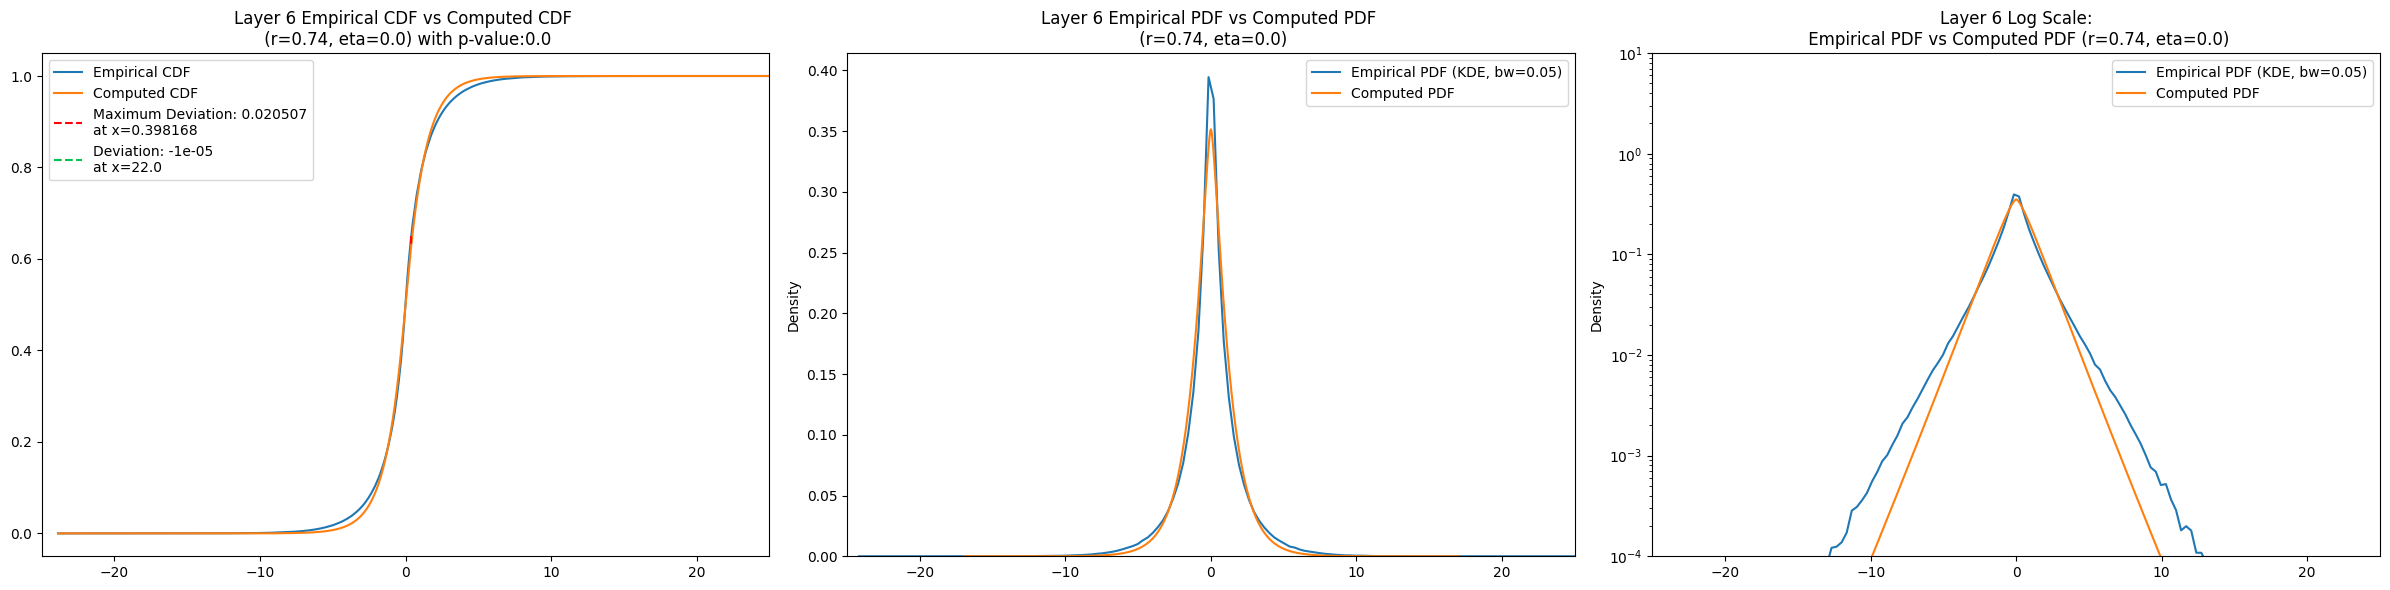

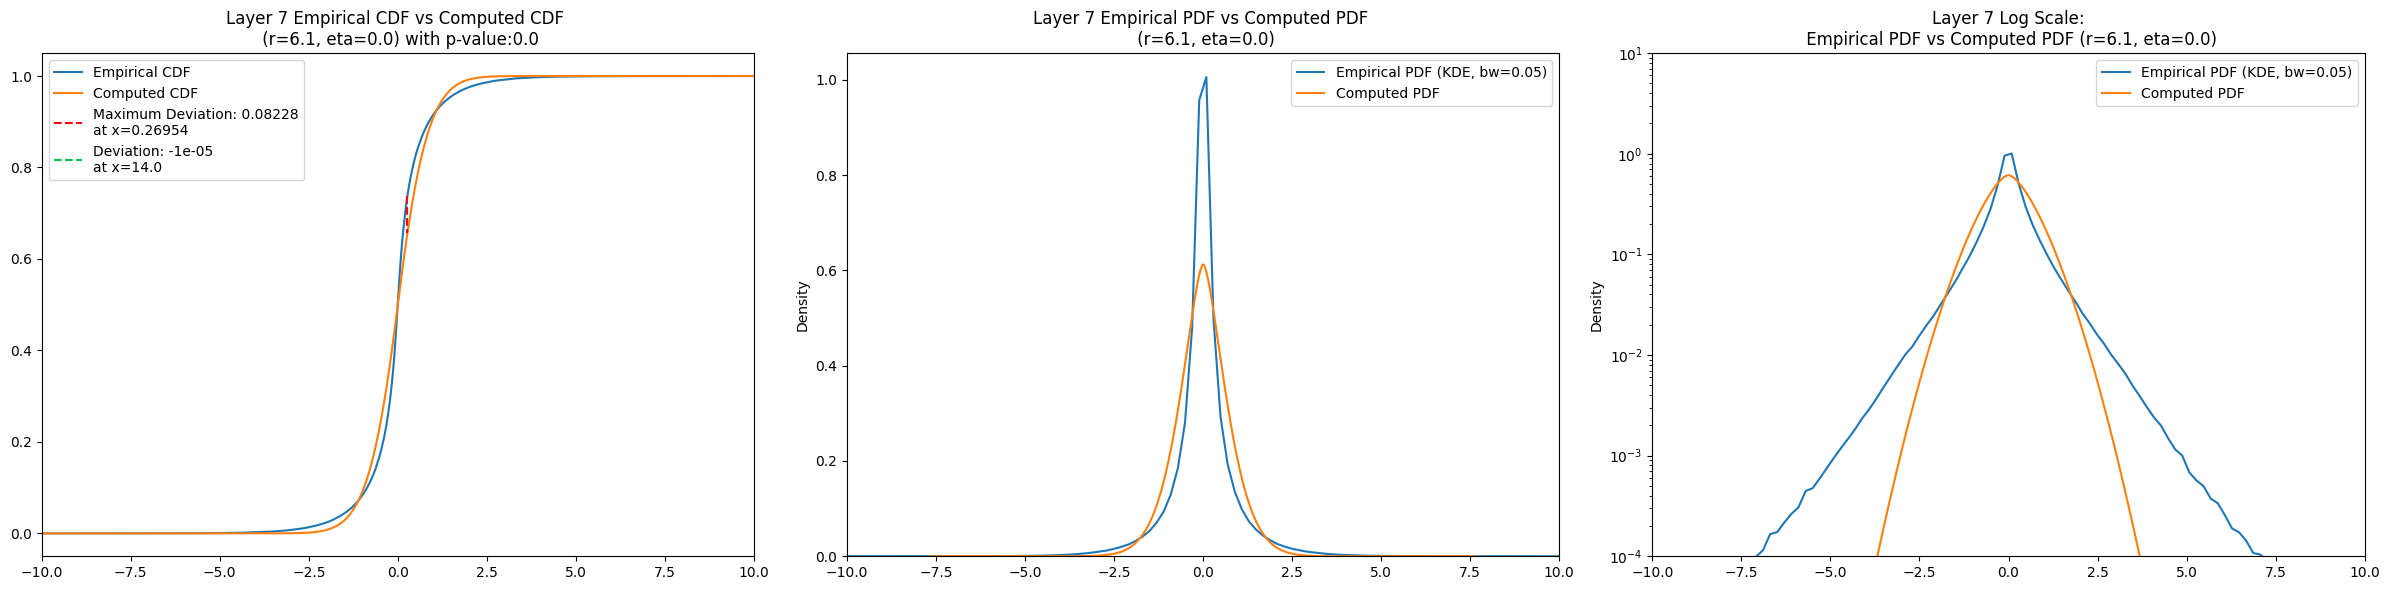

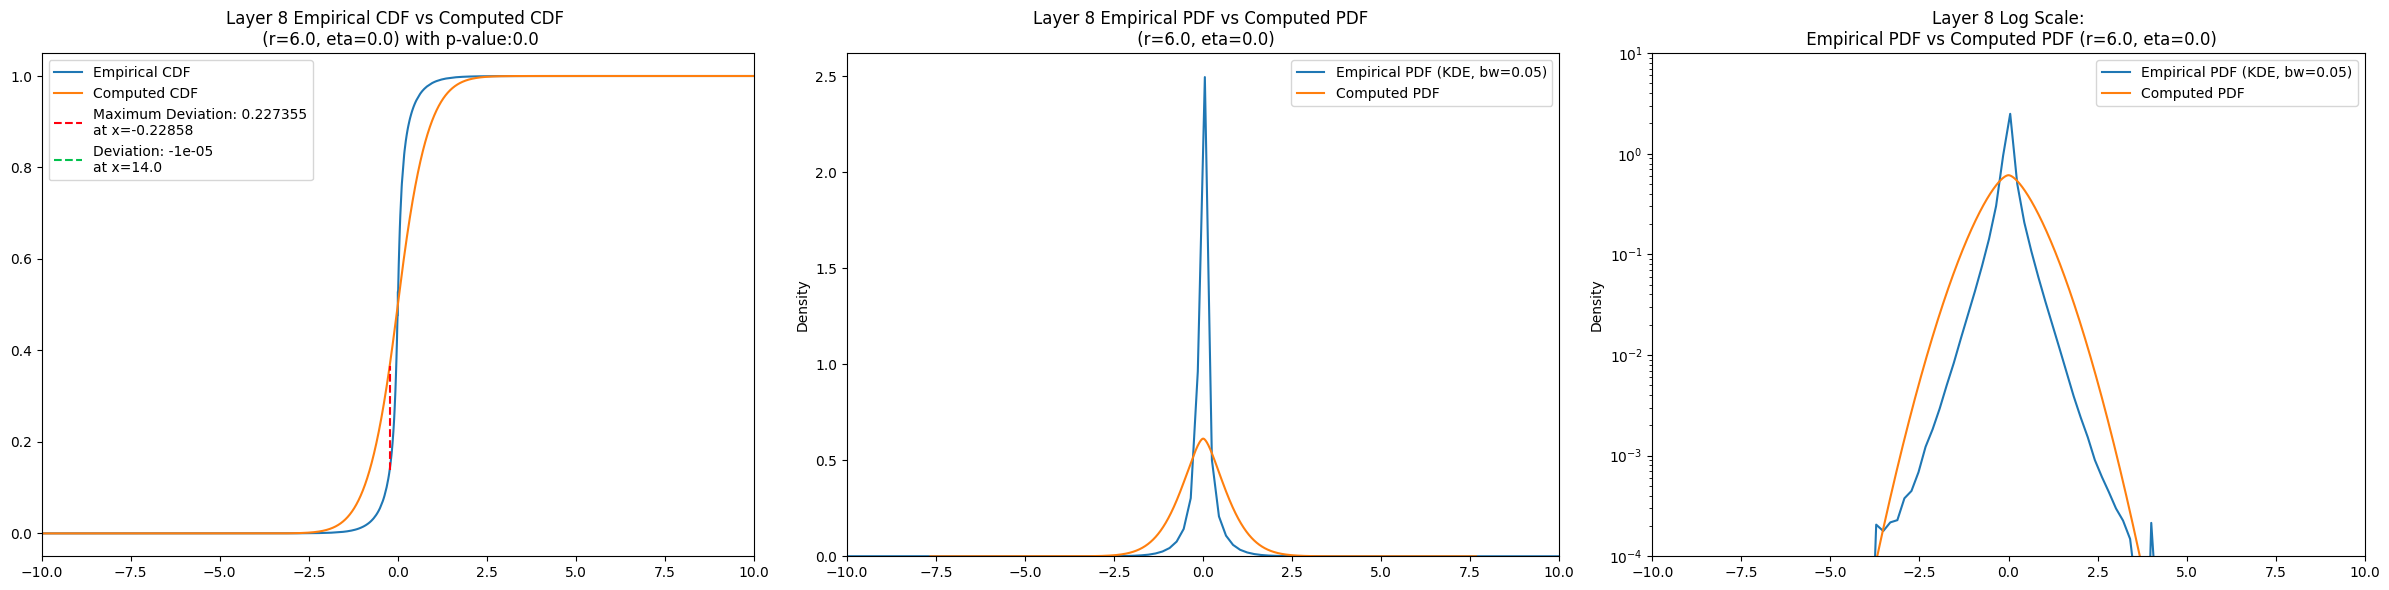

In [9]:
for group in np.arange(min_group, max_group+1):
    group_info = master_df.loc[group]
    fig = visualize_cdf_pdf(sample = group_data_map[group], 
                    params = (group_info[f'best_r_d{r_d}'], group_info[f'best_eta_d{eta_d}']), 
                    log_scale = True,
                    all_cdfs = all_cdfs,
                    group = group,
                    interval = (-(40 - group//3.1*15), (40 - group//3.1*15)),
                    provided_loc=(30 - group//3.1*8))
    fig.savefig(f'{DATA_NAME}/plots/compare_cdf_pdf_layer_{group}.png', bbox_inches = 'tight')

## Comparing with Gaussian and Laplace

In [10]:
SKIP_OPTIMIZE_STEP = True

def coord_descent_scipy(sample, initial_param):
    '''
    '''
    r_0, eta_0 = initial_param
    find_r_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_0), method = 'bounded', bounds = (max(0.5, r_0-0.1), r_0+0.1))
    r_1 = find_r_1['x']
    find_eta_1 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_eta', r_1), method = 'bounded', bounds = (max(0, eta_0-0.1), eta_0+0.1))
    eta_1 = find_eta_1['x']
    find_r_2 = scipy.optimize.minimize_scalar(generate_func(sample, 'gengamma_r', eta_1), method = 'bounded', bounds = (max(0.5, r_1-0.1), r_1+0.1))

    r_2 = find_r_2['x']

    return r_2, eta_1, find_r_2['fun']

if SKIP_OPTIMIZE_STEP:
    master_df[f'best_r_scipy'], master_df[f'best_eta_scipy'], master_df[f'kstest_stat_cd_scipy'] =   master_df[f'best_r_d{r_d}'],  master_df[f'best_eta_d{eta_d}'], master_df['kstest_stat_initial']
else:
    for group in np.arange(min_group, max_group+1):
        master_df.loc[group, f'best_r_scipy'], master_df.loc[group, f'best_eta_scipy'], master_df.loc[group, f'kstest_stat_cd_scipy'] = coord_descent_scipy(group_data_map[group], master_df.loc[group, 'initial_param'])

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_cd_scipy.csv', index_col = 'layer')
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df


,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,n_pval_0.05,best_r_scipy,best_eta_scipy,kstest_stat_cd_scipy
layer,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180,0.024030,0.021670,0.39,4.0,4023,0.39,4.0,0.021670
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720,0.012029,0.008143,0.44,3.7,28620,0.44,3.7,0.008143
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880,0.006018,0.006270,0.44,1.4,48295,0.44,1.4,0.006270
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520,0.003010,0.005235,0.47,0.2,64395,0.47,0.2,0.005235
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080,0.001505,0.020507,0.74,0.0,4525,0.74,0.0,0.020507
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320,0.000753,0.082280,6.10,0.0,279,6.10,0.0,0.082280
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280,0.000376,0.227355,6.00,0.0,36,6.00,0.0,0.227355


In [11]:
for group in np.arange(min_group, max_group+1):
    norm_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'gaussian'), method = 'bounded', bounds = (0, 50))
    laplace_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 'laplace'), method = 'bounded', bounds = (0, 50))
    t_result = scipy.optimize.minimize_scalar(generate_func(group_data_map[group], 't'), method = 'bounded', bounds = (0, 50))
    
    master_df.loc[group, 'param_gaussian'] = round_to_sigfigs(norm_result['x'], 6)
    master_df.loc[group, 'kstest_stat_gaussian'] = round_to_sigfigs(norm_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_gaussian'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_gaussian']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6)

    master_df.loc[group, 'param_laplace'] = round_to_sigfigs(laplace_result['x'], 6)
    master_df.loc[group, 'kstest_stat_laplace'] = round_to_sigfigs(laplace_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_laplace'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_laplace']), 6) 

    master_df.loc[group, 'param_t'] = round_to_sigfigs(t_result['x'], 6)
    master_df.loc[group, 'kstest_stat_t'] = round_to_sigfigs(t_result['fun'], 6)
    master_df.loc[group, 'kstest_pval_t'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'num_samples']).sf(master_df.loc[group, 'kstest_stat_t']), 6) 

    master_df.loc[group, 'kstest_pval_gengamma'] = round_to_sigfigs(stats.kstwo(n=master_df.loc[group, 'total_samples']).sf(min(master_df.loc[group, 'kstest_stat_cd'], master_df.loc[group, 'kstest_stat_cd_scipy'])), 6)

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv')
master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df_post_compare_priors.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,...,param_gaussian,kstest_stat_gaussian,kstest_pval_gaussian,param_laplace,kstest_stat_laplace,kstest_pval_laplace,param_t,kstest_stat_t,kstest_pval_t,kstest_pval_gengamma
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180,0.024030,0.021670,0.39,4.0,...,27.782300,0.019503,1.755550e-01,25.439100,0.036392,4.282210e-04,20.752800,0.036305,4.458110e-04,9.945980e-02
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720,0.012029,0.008143,0.44,3.7,...,16.031400,0.010128,1.460870e-01,14.012900,0.022665,4.151010e-06,11.277100,0.026410,3.854630e-08,3.658630e-01
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880,0.006018,0.006270,0.44,1.4,...,8.001070,0.020474,5.852830e-19,7.104980,0.014498,1.017140e-09,5.719650,0.018489,1.538450e-15,3.644850e-02
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520,0.003010,0.005235,0.47,0.2,...,3.590200,0.030178,1.489490e-79,3.138870,0.002344,6.408470e-01,2.574090,0.010570,3.923130e-10,2.849260e-05
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080,0.001505,0.020507,0.74,0.0,...,1.426190,0.042375,1.823540e-156,1.246800,0.014481,1.209280e-18,1.010540,0.017941,2.174500e-28,7.898030e-298
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320,0.000753,0.082280,6.10,0.0,...,0.539656,0.052929,6.393590e-244,0.472760,0.025282,5.860770e-56,0.378321,0.026440,3.639260e-61,0.000000e+00
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280,0.000376,0.227355,6.00,0.0,...,0.196027,0.056358,1.624990e-276,0.172569,0.029152,2.905530e-74,0.137349,0.028140,3.168650e-69,0.000000e+00


# Examining Tail Behavior

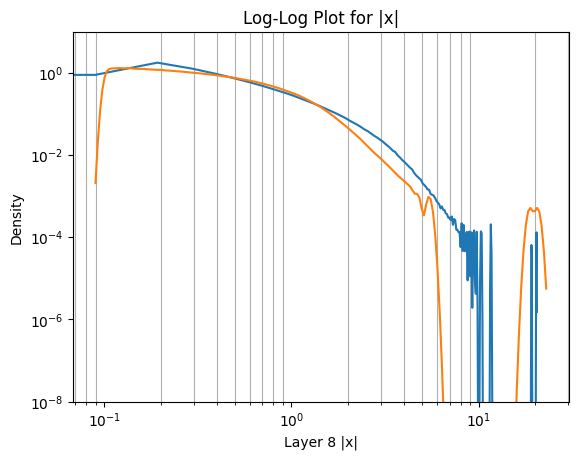

In [12]:
if GROUP == 'layer':
    bw = 0.05
    group = 7
    x = np.abs(group_data_map[group])
    fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
    fig.set_xscale('log')
    fig.set_yscale('log')
    fig.set_ylim(bottom = 10**-8, top=10)
    plt.xlabel(f'Layer {group} |x|')
    plt.title(f'Log-Log Plot for |x|')
    plt.grid(True, 'minor')
    plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_7.png', bbox_inches = 'tight')

    bw = 0.05
    group = 8
    x = np.abs(group_data_map[group])
    fig = sns.kdeplot(x = x[x >= 0.1], bw_method = bw, label = f"Empirical PDF (KDE), bw={bw}")
    fig.set_xscale('log')
    fig.set_yscale('log')
    fig.set_ylim(bottom = 10**-8, top=10)
    plt.xlabel(f'Layer {group} |x|')
    plt.title(f'Log-Log Plot for |x|')
    plt.grid(True, 'minor')
    plt.savefig(f'{DATA_NAME}/plots/log-log_plot_layer_8.png', bbox_inches = 'tight')


In [13]:
def add_metric_tail(metric_name = 'kstest_ratio',  distro = 'gengamma', tail_cutoffs = [0], layers = np.arange(2, 9)):
    if metric_name == 'kstest_ratio':
        metric = compute_ksratio
    elif metric_name == 'kstest_stat':
        metric = compute_ksstat_tail

    for tail_cutoff in tail_cutoffs:
        metrics = []
        for layer in layers:
            if distro == 'gengamma':
                cdf = all_cdfs[master_df.loc[layer, 'initial_param']]
            elif distro == 'gaussian':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_gaussian']).cdf
            elif distro == 'laplace':
                cdf = stats.norm(scale = master_df.loc[layer, 'param_laplace']).cdf
            elif distro == 't':
                cdf = stats.t(df = 2, scale = master_df.loc[layer, 'param_t']).cdf
            metrics.append(metric(group_data_map[layer], cdf, tail_cutoff = tail_cutoff))
        master_df[metric_name + '_' + distro + '_' + f'tail{tail_cutoff}'] = metrics
        
for group in np.arange(min_group, max_group+1):
    add_metric_tail('kstest_ratio', distro = 'gengamma', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 'gaussian', tail_cutoffs= [0,10], layers = np.arange(2, 9)) 
    add_metric_tail('kstest_ratio', distro = 'laplace', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_ratio', distro = 't', tail_cutoffs= [0,10], layers = np.arange(2, 9))
    add_metric_tail('kstest_stat', distro = 'gengamma', tail_cutoffs= [2, 10], layers = np.arange(2, 9))

master_df.to_csv(f'{DATA_NAME}/CSVs/master_df.csv')

master_df = pd.read_csv(f'{DATA_NAME}/CSVs/master_df.csv', index_col = GROUP)
master_df['initial_param'] = [tuple(float(i) for i in master_df.loc[layer]['initial_param'][1:-1].split(',')) for layer in master_df.index]
master_df

c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
c:\Users\yashd\Desktop\hierarchical-bayesian-model-validation\testing-framework\utilities.py:296: RuntimeWarning: divide by zero encountered in divide
  tail_ratios = np.nan_to_num(d[tail_idxs] / tail_vals)
c:\Users\yashd\.conda\envs\hbmv\Lib\site-packages\numpy\core\

,num_samples,initial_param,kstest_stat_initial,best_param_eta_0,kstest_stat_eta0,total_samples,kstest_stat_cutoff_0.05,kstest_stat_cd,best_r_d2,best_eta_d1,...,kstest_ratio_gengamma_tail0,kstest_ratio_gengamma_tail10,kstest_ratio_gaussian_tail0,kstest_ratio_gaussian_tail10,kstest_ratio_laplace_tail0,kstest_ratio_laplace_tail10,kstest_ratio_t_tail0,kstest_ratio_t_tail10,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,,,,,,,,,,,,
2,3180,"(0.39, 4.0)",0.021670,"(0.26, 0)",0.060374,3180,0.024030,0.021670,0.39,4.0,...,"(0.082446, 1.0161)","(0.082446, 1.0161)","(0.9368, 1.9545)","(0.9368, 1.9545)","(0.95089, 7.3557)","(0.95089, 7.3557)","(0.015521, 1.04)","(0.015521, 1.04)",0.021670,0.021670
3,12720,"(0.44, 3.7)",0.008143,"(0.29, 0)",0.037031,12720,0.012029,0.008143,0.44,3.7,...,"(0.095485, 1.0197)","(0.095485, 1.0197)","(0.96671, 76.943)","(0.96671, 76.943)","(0.96151, 2839.9)","(0.96151, 2839.9)","(0.0074015, 1.1147)","(0.0074015, 1.1147)",0.008143,0.008143
4,50880,"(0.44, 1.4)",0.006270,"(0.34, 0)",0.023245,50880,0.006018,0.006270,0.44,1.4,...,"(0.099159, 1.0029)","(0.099159, 1.0029)","(0.93633, 391120.0)","(0.97872, 391120.0)","(0.95756, 119260000.0)","(0.95756, 119260000.0)","(0.003275, 1.0744)","(0.003275, 1.0176)",0.005811,0.005487
5,100000,"(0.47, 0.2)",0.005235,"(0.44, 0)",0.005645,203520,0.003010,0.005235,0.47,0.2,...,"(0.29176, 6871.1)","(0.29176, 6871.1)","(0.90723, 1.8721999999999998e+35)","(0.98075, 1.8721999999999998e+35)","(0.95007, 1.8763e+47)","(0.97884, 1.8763e+47)","(0.006972, 1.0662)","(0.006972, 1.0104)",0.003325,0.001370
6,100000,"(0.74, 0.0)",0.020507,"(0.74, 0)",0.020507,814080,0.001505,0.020507,0.74,0.0,...,"(0.9465, 207510.0)","(0.99916, 207510.0)","(0.87959, 3.0205e+57)","(0.99905, 3.0205e+57)","(0.9364, 2.0407000000000003e+76)","(0.99905, 2.0407000000000003e+76)","(0.011194, 1.2183)","(0.011194, 1.0041)",0.019270,0.000847
7,100000,"(6.1, 0.0)",0.082280,"(6.1, 0)",0.082280,3256320,0.000753,0.082280,6.10,0.0,...,"(0.72842, 1637700000000.0)","(0.99998, 14392000000.0)","(0.8501, 6.528000000000002e+269)","(0.99998, 6.528000000000002e+269)","(0.90641, inf)","(0.99998, inf)","(0.037871, 1.5063)","(0.037871, 1.0006)",0.016800,0.000030
8,100000,"(6.0, 0.0)",0.227355,"(6.0, 0)",0.227355,13025280,0.000376,0.227355,6.00,0.0,...,"(0.13064, 1033300000.0)","(1.0, 1033300000.0)","(0.83653, inf)","(1.0, inf)","(0.89532, inf)","(1.0, inf)","(0.061503, 1.7144)","(0.37126, 1.0)",0.006442,0.000010


# Results

In [14]:
#master_df.filter(regex='num_samples|kstest_stat.*')
#master_df.filter(regex='num_samples|param.*')
# master_df.filter(regex='.*gaussian')
master_df.filter(regex='kstest_stat_.*')
#master_df.filter(regex='.*_tail\d\d?')
#master_df.filter(regex='.*_t_.*')


,kstest_stat_initial,kstest_stat_eta0,kstest_stat_cutoff_0.05,kstest_stat_cd,kstest_stat_cd_scipy,kstest_stat_gaussian,kstest_stat_laplace,kstest_stat_t,kstest_stat_gengamma_tail2,kstest_stat_gengamma_tail10
layer,,,,,,,,,,
2,0.021670,0.060374,0.024030,0.021670,0.021670,0.019503,0.036392,0.036305,0.021670,0.021670
3,0.008143,0.037031,0.012029,0.008143,0.008143,0.010128,0.022665,0.026410,0.008143,0.008143
4,0.006270,0.023245,0.006018,0.006270,0.006270,0.020474,0.014498,0.018489,0.005811,0.005487
5,0.005235,0.005645,0.003010,0.005235,0.005235,0.030178,0.002344,0.010570,0.003325,0.001370
6,0.020507,0.020507,0.001505,0.020507,0.020507,0.042375,0.014481,0.017941,0.019270,0.000847
7,0.082280,0.082280,0.000753,0.082280,0.082280,0.052929,0.025282,0.026440,0.016800,0.000030
8,0.227355,0.227355,0.000376,0.227355,0.227355,0.056358,0.029152,0.028140,0.006442,0.000010
